<a href="https://colab.research.google.com/github/Jwangombe11/Classification/blob/main/South_Africa_Language__Identification__Jackies_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Honour Code
I Jacqueline, Wang'ombe, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code (https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

<a name="Libraries"></a>
## 1. Importing libraries

In [1]:
import re
import string
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.utils import resample

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#from comet_ml import Experiment

# Setting global constants to ensure notebook results are reproducible

RANDOM_STATE = 42


import warnings
warnings.filterwarnings('ignore')

<a name="Data"></a>
## 2. Loading data

In [5]:
# Load files
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')
samplesubmission = pd.read_csv('sample_submission.csv')


# Preview train dataset
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
# Preview test dataset
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [6]:
# Preview sample submission file
samplesubmission.head()

,index,lang_id
0,1,tsn
1,2,nbl


In [7]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((33000, 2), (5682, 2), (2, 2))

The train data has two columns(lang_id, text), the test data has two columns(index, text) and the sampl submission (index, lang_id. Train data has 33000 observations while the test data has 5682 observations.

<a name="Statistics"></a>
## 3. Statistical summaries

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [9]:
# Check for missing values
train.isnull().sum()

lang_id    0
text       0
dtype: int64

There are no missing values in the train data set.

In [10]:
# Train statistical summary
train.describe(include = 'all')

,lang_id,text
count,33000,33000
unique,11,29948
top,xho,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


From the above statistical summary, we can deduce some of the following insights:
 - Both columns have a total of 33000 observation
 - There are 11 unique lang_id.
 - The xho lang_id is the most common occuring 3000 times.

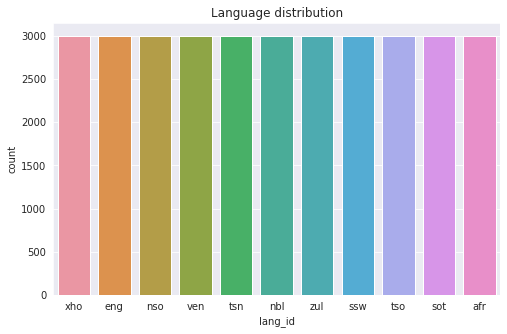

In [11]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["lang_id"])
plt.title('Language distribution')
plt.show()

The target variable is well balanced.

# Data engineering

In [12]:
train['totalwords'] = train['text'].str.split().str.len()
train.head()

,lang_id,text,totalwords
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,24
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,31
2,eng,the province of kwazulu-natal department of tr...,37
3,nso,o netefatša gore o ba file dilo ka moka tše le...,40
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,43


In [13]:
train['totalwords'].sum()

1225280

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stop_words = set(stopwords.words('english'))

train['stopwords'] = train['text'].str.split().apply(lambda x: len(set(x) & stop_words))
train.head()

,lang_id,text,totalwords,stopwords
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,24,0
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,31,0
2,eng,the province of kwazulu-natal department of tr...,37,7
3,nso,o netefatša gore o ba file dilo ka moka tše le...,40,2
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,43,1


In [17]:
train['stopwords'].sum()

58792

In [18]:
perc_stopwords = (train['stopwords'].sum()/train['totalwords'].sum())*100
#print('The percentage of stopwords is:' %per_stopwords)
perc_stopwords

4.798250195873596

In [19]:
# define a function for extracting
# the punctuations
import re
def check_find_punctuations(text):
    
    # regular expression containing
    # all punctuation
    result = re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', 
                        text)
      
    # form a string
    string = "".join(result)
      
    # list of strings return
    return string
    
# creating new column name
# as a punctuation_used and 
# applying user defined function
# on each rows of Comments column
train['punctuation_used'] = train['text'].apply(
                         lambda x : check_find_punctuations(x)
                         )
  
# show the Dataframe
train.head()

,lang_id,text,totalwords,stopwords,punctuation_used
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,24,0,-
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,31,0,--
2,eng,the province of kwazulu-natal department of tr...,37,7,-
3,nso,o netefatša gore o ba file dilo ka moka tše le...,40,2,
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,43,1,


<a name="Statistics"></a>
## 1. Text preprocessing

In [20]:
import string
def remove_punc(data, col):
    """
        This function takes in a dataframe and a column, uses python string package to identify and remove all
        punctions in the column. It returns a new dataframe
    """
   
    def operation(x):
        x = re.sub(r'[-]',' ',x)
        x = re.sub(r'[_]', ' ', x)
        x = re.sub(r'[^\w\s]','',x)
        x = re.sub('[0-9]+', '', x)
        x = re.sub(r'[^\x00-\x7f]',r'', x)
        return x
        
    
    df = data.copy()
    #df[col] = df[col].str.lower()
    
    df['text_no_punc'] = df[col].apply(operation)
    
    return df

In [21]:
# Create a new dataframe with text column void of punctuation
new_train = remove_punc(train, 'text')
new_train.head()

,lang_id,text,totalwords,stopwords,punctuation_used,text_no_punc
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,24,0,-,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,31,0,--,i dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...,37,7,-,the province of kwazulu natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,40,2,,o netefata gore o ba file dilo ka moka te le d...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,43,1,,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [22]:
def word_converter(data, col):
    """
        This function takes in a dataframe and col, converts all capitalized words in the column to lowercase,
        and returns a new dataframe.
    """
    df = data.copy()
    df['text_lower'] = df[col].str.lower()
    return df

In [23]:
new_train = word_converter(new_train, 'text_no_punc')
new_train.head()

,lang_id,text,totalwords,stopwords,punctuation_used,text_no_punc,text_lower
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,24,0,-,umgaqo siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,31,0,--,i dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...,37,7,-,the province of kwazulu natal department of tr...,the province of kwazulu natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,40,2,,o netefata gore o ba file dilo ka moka te le d...,o netefata gore o ba file dilo ka moka te le d...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,43,1,,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [24]:
# Drop every other columns except lang_id and text_lower columns
train_reduced = new_train[['lang_id', 'text_lower']]
train_reduced.head()

,lang_id,text_lower
0,xho,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,i dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu natal department of tr...
3,nso,o netefata gore o ba file dilo ka moka te le d...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [25]:
le = LabelEncoder()
train_reduced["lang_id"] = le.fit_transform(train_reduced["lang_id"])
train_reduced.head()

,lang_id,text_lower
0,9,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,9,i dha iya kuba nobulumko bokubeka umsebenzi na...
2,1,the province of kwazulu natal department of tr...
3,3,o netefata gore o ba file dilo ka moka te le d...
4,8,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [26]:
#Extract dependant for data set
y = train_reduced["lang_id"]

Preprocess test data

In [27]:
# Create a new dataframe with text void of punctuation marks
new_test = remove_punc(test, 'text')
new_test.head()

,index,text,text_no_punc
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...",Mmasepala fa maemo a a kgethegileng a letlelel...
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,Tshivhumbeo tshi fana na ngano dza vhathu
3,4,Kube inja nelikati betingevakala kutsi titsini...,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.,Winste op buitelandse valuta


In [28]:
new_test = word_converter(new_test, 'text_no_punc')
new_test.head()

,index,text,text_no_punc,text_lower
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...",Mmasepala fa maemo a a kgethegileng a letlelel...,mmasepala fa maemo a a kgethegileng a letlelel...
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,Tshivhumbeo tshi fana na ngano dza vhathu,tshivhumbeo tshi fana na ngano dza vhathu
3,4,Kube inja nelikati betingevakala kutsi titsini...,Kube inja nelikati betingevakala kutsi titsini...,kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.,Winste op buitelandse valuta,winste op buitelandse valuta


In [29]:
test_reduced = new_test[['index','text_lower']]
test_reduced.tail()

,index,text_lower
5677,5678,you mark your ballot in private
5678,5679,ge o ka kgetha ka bowena go se omie mofani ka ...
5679,5680,e ka kopo etsa kgetho ya hao ka hloko hobane h...
5680,5681,tb ke bokudi ba pmb mme morero o tla lefella t...
5681,5682,vakatjhela iwebhusayidi yethu ku www


In [30]:
cv = TfidfVectorizer(stop_words='english', min_df=2, max_df= 0.9, ngram_range=(1, 5), analyzer= 'char')

X_train_clean = cv.fit_transform(train_reduced['text_lower'])
X_test_clean = cv.transform(test_reduced['text_lower'])

In [31]:
X_train_clean.shape

(33000, 246631)

In [32]:
X_test_clean.shape

(5682, 246631)

<a name="Statistics"></a>
# 1. Modelling

Logistic Regression Model

In [33]:
# get training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X_train_clean, y, test_size=0.3, random_state=42)

In [ ]:
logreg_model = LogisticRegression()

In [ ]:
logreg_model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [ ]:
#predicting the 
y_pred_test = logreg_model.predict(X_test)

In [ ]:
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred_test))



Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00       909
           2       1.00      1.00      1.00       879
           3       1.00      1.00      1.00       941
           4       1.00      1.00      1.00       918
           5       1.00      1.00      1.00       908
           6       1.00      1.00      1.00       882
           7       1.00      1.00      1.00       857
           8       1.00      1.00      1.00       936
           9       1.00      1.00      1.00       922
          10       0.99      0.99      0.99       853

    accuracy                           1.00      9900
   macro avg       1.00      1.00      1.00      9900
weighted avg       1.00      1.00      1.00      9900



In [ ]:
y_pred_test_new = logreg_model.predict(X_test_clean)

In [ ]:
# Creating a datframe with the lang_id and predicted y columns
df1 = pd.DataFrame({
    'index': test['index'],
    'lang_id': y_pred_test_new
})

df1.head()

,index,lang_id
0,1,6
1,2,2
2,3,8
3,4,5
4,5,0


In [ ]:
#Converting the lang_id from numeric to text
df1['lang_id'] = le.inverse_transform(df1['lang_id'])

df1.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


In [ ]:
# Downloading the sample csv for logreg_model
df1.to_csv('file_lr11.csv',index=False)

Hyperparameter tuning of logistic regression

1. Using grid search to find the best C

In [ ]:
logreg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1]}

In [ ]:

# Training and testing using GridSearch
clf = GridSearchCV(logreg,
                   param_grid=param_grid,
                   cv=10,
                   n_jobs=-1)

clf.fit(X_train, y_train)


In [ ]:
y_pred_hlr = clf.predict(X_test)

In [ ]:
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred_hlr))



Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       0.99      1.00      1.00       909
           2       0.98      0.99      0.99       879
           3       1.00      1.00      1.00       941
           4       1.00      1.00      1.00       918
           5       1.00      0.99      1.00       908
           6       1.00      1.00      1.00       882
           7       1.00      1.00      1.00       857
           8       1.00      1.00      1.00       936
           9       0.99      0.99      0.99       922
          10       0.98      0.98      0.98       853

    accuracy                           1.00      9900
   macro avg       1.00      1.00      1.00      9900
weighted avg       1.00      1.00      1.00      9900



In [ ]:
y_pred_hlr2 = clf.predict(X_test_rl)

In [ ]:
# Creating a datframe with the lang_id and predicted y columns
df2 = pd.DataFrame({
    'index': test['index'],
    'lang_id': y_pred_hlr2
})

df2.head()

,index,lang_id
0,1,5
1,2,2
2,3,8
3,4,5
4,5,2


In [ ]:
#Converting the lang_id from numeric to text
df2['lang_id'] = le.inverse_transform(df2['lang_id'])

df2.head()

,index,lang_id
0,1,ssw
1,2,nbl
2,3,ven
3,4,ssw
4,5,nbl


In [ ]:
# Downloading the sample csv for logreg_model
df2.to_csv('file_glr.csv',index=False)

2. Selection by Choosing K-Best Features

In [ ]:
# lm instance for k-best
lm_kbest = LogisticRegression()

In [ ]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=150000)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y)

In [ ]:
X_train_kbest.shape

(33000, 150000)

In [ ]:
# Fit model to the transformed data
lm_kbest.fit(X_train_kbest, y)

LogisticRegression()

In [ ]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(X_test)

# Generate predictions from var thresh model
pred_lm_kbest = lm_kbest.predict(X_test_kbest)

In [ ]:
# Creating a datframe with the lang_id and predicted y columns
df3 = pd.DataFrame({
    'index': test['index'],
    'lang_id': pred_lm_kbest
})

df3.head()

,index,lang_id
0,1,5
1,2,2
2,3,8
3,4,5
4,5,5


In [ ]:
#Converting the lang_id from numeric to text
df3['lang_id'] = le.inverse_transform(df3['lang_id'])

df3.head()

,index,lang_id
0,1,ssw
1,2,nbl
2,3,ven
3,4,ssw
4,5,ssw


In [ ]:
# Downloading the sample csv for best logreg_model
df3.to_csv('file_kblr.csv',index=False)

3. Using Support Vector Machines

In [ ]:
svc = SVC(kernel='rbf')

In [ ]:
svc.fit(X_train, y)

SVC()

In [ ]:
y_pred_svc = svc.predict(X_test)

In [ ]:
# Creating a datframe with the lang_id and predicted y columns
df4 = pd.DataFrame({
    'index': test['index'],
    'lang_id': y_pred_svc
})

df4.head()

,index,lang_id
0,1,2
1,2,2
2,3,8
3,4,5
4,5,2


In [ ]:
#Converting the lang_id from numeric to text
df4['lang_id'] = le.inverse_transform(df4['lang_id'])

df4.head()

,index,lang_id
0,1,nbl
1,2,nbl
2,3,ven
3,4,ssw
4,5,nbl


In [ ]:
# Downloading the sample csv for best logreg_model
df4.to_csv('file_svc.csv',index=False)

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':(0.25,1.0),
              'gamma': (1,2)}

In [ ]:
svm = SVC()
clf = GridSearchCV(svm, parameters)


In [ ]:
clf.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': (0.25, 1.0), 'gamma': (1, 2),
                         'kernel': ('linear', 'rbf')})

In [ ]:
y_pred_svc2 = clf.predict(X_test)

In [ ]:
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred_svc2))



Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.99      1.00       895
           1       1.00      1.00      1.00       909
           2       0.98      0.99      0.99       879
           3       1.00      1.00      1.00       941
           4       1.00      1.00      1.00       918
           5       1.00      1.00      1.00       908
           6       1.00      1.00      1.00       882
           7       1.00      1.00      1.00       857
           8       1.00      1.00      1.00       936
           9       0.99      1.00      1.00       922
          10       0.99      0.99      0.99       853

    accuracy                           1.00      9900
   macro avg       1.00      1.00      1.00      9900
weighted avg       1.00      1.00      1.00      9900



In [ ]:
y_pred_rl = clf.predict(X_test_rl)

In [ ]:
# Creating a datframe with the lang_id and predicted y columns
df8 = pd.DataFrame({
    'index': test['index'],
    'lang_id': y_pred_rl
})

df8.head()

,index,lang_id
0,1,2
1,2,2
2,3,8
3,4,5
4,5,2


In [ ]:
#Converting the lang_id from numeric to text
df8['lang_id'] = le.inverse_transform(df8['lang_id'])

df8.head()

,index,lang_id
0,1,nbl
1,2,nbl
2,3,ven
3,4,ssw
4,5,nbl


In [ ]:
# Downloading the sample csv for best svc model
df8.to_csv('file_gsvc.csv',index=False)

4. Multinomial Naive Bayes

In [34]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()


In [35]:
model.fit(X_train, y_train)

MultinomialNB()

In [36]:
y_pred_mnb = model.predict(X_test)

In [37]:
#Creating a classification Report
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred_mnb))



Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00       909
           2       1.00      1.00      1.00       879
           3       1.00      1.00      1.00       941
           4       1.00      1.00      1.00       918
           5       1.00      1.00      1.00       908
           6       1.00      1.00      1.00       882
           7       1.00      1.00      1.00       857
           8       1.00      1.00      1.00       936
           9       1.00      0.99      1.00       922
          10       0.99      1.00      1.00       853

    accuracy                           1.00      9900
   macro avg       1.00      1.00      1.00      9900
weighted avg       1.00      1.00      1.00      9900



In [38]:
y_pred_test_mnb = model.predict(X_test_clean)

In [39]:
# Creating a datframe with the lang_id and predicted y columns
df12 = pd.DataFrame({
    'index': test['index'],
    'lang_id': y_pred_test_mnb
})

df12.head()

,index,lang_id
0,1,6
1,2,2
2,3,8
3,4,5
4,5,0


In [40]:
#Converting the lang_id from numeric to text
df12['lang_id'] = le.inverse_transform(df12['lang_id'])

df12.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


In [42]:
# Downloading the sample csv for Multinomial NB model
df12.to_csv('file_mnb.csv',index=False)